In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import talib 
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib.colors import ListedColormap
from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



In [3]:
startdate = '2016-01-1'
enddate= '2021-12-31'
scaler = MinMaxScaler()

In [4]:
dji = pdr.get_data_yahoo('^DJI', start=startdate, end=enddate)
dji_norm = pd.DataFrame(scaler.fit_transform(dji), columns=dji.columns)
n225 = pdr.get_data_yahoo("^N225", start=startdate, end=enddate)
n225_norm = pd.DataFrame(scaler.fit_transform(n225), columns=n225.columns)
hsi = pdr.get_data_yahoo("^HSI", start=startdate, end=enddate)
hsi_norm = pd.DataFrame(scaler.fit_transform(hsi), columns=hsi.columns)
sse = pdr.get_data_yahoo("000001.SS", start=startdate, end=enddate)
sse_norm = pd.DataFrame(scaler.fit_transform(sse), columns=sse.columns)


<h1>Dow Jones Industrial Average</h1>

<h2>Feature Selection</h2>

In [5]:
dji['Future Close'] = dji['Close'].shift(-1)
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2015-12-31,17590.660156,17421.160156,17590.660156,17425.029297,93690000,17425.029297,17148.939453
2016-01-04,17405.480469,16957.630859,17405.480469,17148.939453,148060000,17148.939453,17158.660156
2016-01-05,17195.839844,17038.609375,17147.500000,17158.660156,105750000,17158.660156,16906.509766
2016-01-06,17154.830078,16817.619141,17154.830078,16906.509766,120250000,16906.509766,16514.099609
2016-01-07,16888.359375,16463.630859,16888.359375,16514.099609,176240000,16514.099609,16346.450195
...,...,...,...,...,...,...,...
2021-11-23,35841.519531,35542.871094,35619.921875,35813.800781,392520000,35813.800781,35804.378906
2021-11-24,35825.468750,35591.031250,35752.308594,35804.378906,280960000,35804.378906,34899.339844
2021-11-26,35366.691406,34749.800781,35366.691406,34899.339844,324580000,34899.339844,35135.941406


In [6]:
def computeTarget(present_price, future_price):
    score = (( future_price - present_price ) / present_price ) * 100
    target = []
    for i in score:
        if i > 0.01:
            target.append(1)
        elif i <= 0.01:
            target.append(0)
        else:
            target.append(0)
    return target
# 1 = up, 0 = down

In [7]:

target = computeTarget(dji['Close'], dji['Future Close'])

dji['Target'] = target


In [8]:
close = dji['Close']
high = dji['High']
low = dji['Low']
open = dji['Open']
volume  = dji['Volume']

In [9]:
dji_ti = pd.DataFrame()
dji_ti['SMA20'] = talib.SMA(close, timeperiod=20)
dji_ti['SMA50'] = talib.SMA(close, timeperiod=50)
dji_ti['SMA200'] = talib.SMA(close, timeperiod=200)
dji_ti['EMA'] = talib.EMA(close, timeperiod=14)
dji_ti['OBV'] = talib.OBV(close, volume)
dji_ti['RSI14'] = talib.RSI(close, timeperiod=14)
dji_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
dji_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
dji_ti['aroondown'], dji_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
dji_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
dji_ti['BOP'] = talib.BOP(open, high, low, close)
dji_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
dji_ti['CMO'] = talib.CMO(close, timeperiod=14)
dji_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
dji_ti['macd'],dji_ti['macdsignal'],dji_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
dji_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
dji_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
dji_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
dji_ti['MOM'] = talib.MOM(close, timeperiod=14)
dji_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
dji_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
dji_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['ROC'] = talib.ROC(close, timeperiod=10)
dji_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
dji_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
dji_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
dji_ti['slowk'], dji_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
dji_ti['fastk'], dji_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
dji_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
dji_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
dji_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
dji_ti['Target'] = dji['Target']
dji_ti['Re Target'] = dji['Close']
dji_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,9.369000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17425.029297
2016-01-04,NaN,NaN,NaN,NaN,-5.437000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,17148.939453
2016-01-05,NaN,NaN,NaN,NaN,5.138000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17158.660156
2016-01-06,NaN,NaN,NaN,NaN,-6.887000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16906.509766
2016-01-07,NaN,NaN,NaN,NaN,-2.451100e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16514.099609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,35976.866797,35238.570391,34276.529502,35877.057083,4.029587e+10,51.833578,18.569595,20.727316,100.000000,21.428571,...,98.606333,19.479109,16.641838,43.923044,19.479109,0.059440,40.099397,-73.512519,0,35813.800781
2021-11-24,35992.551172,35258.370156,34298.362393,35867.366660,4.001491e+10,51.576985,17.811202,20.964972,92.857143,14.285714,...,99.236245,38.711528,24.643130,63.820092,38.711528,0.059878,44.607981,-74.433650,0,35804.378906
2021-11-26,35950.994141,35261.330547,34315.705596,35738.296418,3.969033e+10,34.109686,19.447525,22.442660,100.000000,7.142857,...,97.155190,40.139149,32.776595,12.674312,40.139149,0.059385,35.974968,-91.765151,1,34899.339844


In [10]:
dji_target = dji_ti.tail(1)
dji_target
dji_ti = dji_ti.dropna()

In [11]:
def selectFeatures(df, target):
    #Split the features and target data
    #select the first 13 columns as features
    X = df.drop(target, axis=1)  # Feature Matrix
    #Select the last column for target 
    Y = df[target]               # Target Variable

    #Build a logistic regression model 
    model = LinearRegression()
    #Define RFE 
    rfe = RFE(model)
    #Use RFE to select the top 5 features 
    fit = rfe.fit(X, Y)

    #Create a dataframe for the results 
    df_RFE_results = []
    for i in range(X.shape[1]):
        df_RFE_results.append(
            {      
                'Feature_names': X.columns[i],
                'Selected':  rfe.support_[i],
                'RFE_ranking':  rfe.ranking_[i],
            }
        )

    df_RFE_results = pd.DataFrame(df_RFE_results)
    df_RFE_results.index.name='Columns'
    ti = []
    for index, row in df_RFE_results.iterrows():
        if row['Selected'] == True:
            ti.append(row['Feature_names']) 
    return ti

In [12]:
dji_features = selectFeatures(dji_ti,'Target')
dji_features

['RSI14',
 'ADX',
 'ADXR',
 'aroondown',
 'APO',
 'BOP',
 'CCI',
 'CMO',
 'macdhist',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [13]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# def visualize(title, xlabel, ylabel, classifier, X_test, y_test):
#     X_set, y_set = X_test, y_test
#     X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                          np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
#     plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#                  alpha = 0.75, cmap = ListedColormap(('lightblue', 'cornsilk')))
#     plt.xlim(X1.min(), X1.max())
#     plt.ylim(X2.min(), X2.max())

#     for i, j in enumerate(np.unique(y_set)):
#         plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend()
#     plt.show()

<h2>Decision Tree</h2>

In [16]:
# Decision Tree Classifier: Create and Train the model
#
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

In [18]:
# Look at the actual y_test
#
#y_test


In [19]:
from sklearn import metrics
cla = "classification"
reg = "regression"
def evaluate(task, y_test, y_pred):
    evaluate = []
    if task == cla:
        evaluate.append(metrics.accuracy_score(y_test, y_pred))
        evaluate.append(metrics.confusion_matrix(y_test, y_pred))
        evaluate.append(metrics.f1_score(y_test, y_pred))
        evaluate.append(metrics.precision_score(y_test, y_pred))
        evaluate.append(metrics.recall_score(y_test, y_pred))
        evaluate.append(metrics.roc_auc_score(y_test, y_pred))
    elif task == reg:
        evaluate.append(metrics.mean_absolute_error(y_test, y_pred))
        evaluate.append(metrics.mean_squared_error(y_test, y_pred))
    return evaluate


In [20]:
def printEval(task, evaluation):
    if task == cla:
        print("Accuracy Score: ", evaluation[0])
        print("Confusion Matrix: \n", evaluation[1])
        print("F1 Score: ", evaluation[2])
        print("Precision Score: ", evaluation[3])
        print("Recall score: ", evaluation[4])
        print("Area Under Curve score: ", evaluation[5])
    elif task == reg:
        print("Mean Absolute Error: ", evaluation[0])
        print("Mean Squared Error", evaluation[1])

In [21]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)


Accuracy Score:  0.525096525096525
Confusion Matrix: 
 [[54 49]
 [74 82]]
F1 Score:  0.5714285714285715
Precision Score:  0.6259541984732825
Recall score:  0.5256410256410257
Area Under Curve score:  0.5249564351506099


<h2>Random Forest</h2>

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [23]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=2)
forest.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_23104/3312196032.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=42)

In [24]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [25]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.5984555984555985
Confusion Matrix: 
 [[  1 102]
 [  2 154]]
F1 Score:  0.7475728155339806
Precision Score:  0.6015625
Recall score:  0.9871794871794872
Area Under Curve score:  0.49844411252178245


<h2>Logistic Regression</h2>

In [26]:
# Logistic Regression Classifier: Create and Train the model
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [27]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

In [28]:
# Look at the actual y_test
y_test

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
    

In [29]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.5366795366795367
Confusion Matrix: 
 [[ 20  83]
 [ 37 119]]
F1 Score:  0.6648044692737429
Precision Score:  0.5891089108910891
Recall score:  0.7628205128205128
Area Under Curve score:  0.4784976350510331


<h2>XGBoost</h2>

In [30]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[18:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], dtype=int64)

In [32]:
y_test

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
    

In [33]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5791505791505791
Confusion Matrix: 
 [[59 44]
 [65 91]]
F1 Score:  0.6254295532646048
Precision Score:  0.674074074074074
Recall score:  0.5833333333333334
Area Under Curve score:  0.578074433656958


<h2>Linear Regression</h2>

In [34]:
dji_features = selectFeatures(dji_ti,'Re Target')
dji_features

['SMA20',
 'EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'Target']

In [35]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 2.16421328e+03  2.18733386e+03 -1.24143874e+13  2.20332427e+01
   2.63541155e+01  1.24143874e+13  1.84247946e+02  1.15920534e+01
   1.32555691e+02 -5.14430476e+02 -1.61010389e+02  3.90605555e+02
  -5.94548131e+00 -2.76035747e+14  2.76035747e+14 -1.68727549e+01
   6.45228940e+01  1.75644924e+01 -1.66798404e+00]]
Intercept: [26275.7098235]


In [39]:
predicted = lr.predict(X_train)
print(predicted)

[[25926.03161355]
 [26223.25619319]
 [24114.94772718]
 ...
 [35616.29219005]
 [23436.65986544]
 [26806.25956291]]


In [40]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [41]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Absolute Error:  26657.14508174469
Mean Squared Error 730271134.9479638


<AxesSubplot:>

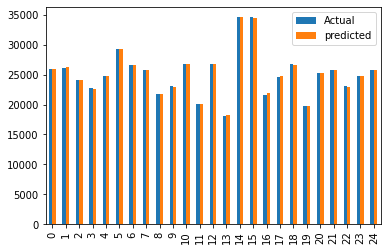

In [42]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gauccian Process Regress</h2>

In [43]:
dji_refeatures = selectFeatures(dji_ti,'Re Target')
dji_refeatures

['SMA20',
 'EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'Target']

In [44]:
Xr = dji_ti.loc[:, dji_refeatures].values
yr = dji_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [45]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
gs = GaussianProcessRegressor()
gs.fit(Xr_train, yr_train)

GaussianProcessRegressor()

In [47]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[16571.37048216],
       [28213.02158031],
       [ 2467.9670095 ],
       [14641.95635735],
       [26835.70688941],
       [ 9964.61946864],
       [19916.81468053],
       [13416.15251828],
       [27834.97658628],
       [ 3158.29738427],
       [28464.46795064],
       [ 2255.7432261 ],
       [25390.83734943],
       [ 7107.23362323],
       [26068.32763249],
       [16641.68686138],
       [21321.42093761],
       [29451.53259474],
       [13573.92376483],
       [17350.61967859],
       [18814.37344315],
       [10305.02827253],
       [23773.05211008],
       [16027.97533093],
       [15526.27628636],
       [13988.72130658],
       [16741.79868425],
       [14102.53086032],
       [23850.90979504],
       [  833.5227619 ],
       [15355.2653677 ],
       [11270.37444775],
       [22649.45116253],
       [21586.19229759],
       [25844.51506352],
       [15501.32175143],
       [10763.52212253],
       [27245.71782841],
       [23947.68662901],
       [28021.00633266],


In [48]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Mean Absolute Error:  8675.190077495086
Mean Squared Error 126084051.05359273


In [49]:
def avg(evaluation):
    return sum(evaluation) / len(evaluation)

In [50]:
def finalEvaluate(pred):
    down = pred.count(0)
    up = pred.count(1)
    upText = "The final prediction is Up"
    downText = "The final prediction is Down"
    print(pred)
    if up > down:
        print(upText)
        return True
    elif up < down:
        print(downText)
        return True
    else:
        return False

In [51]:
def finalPredict(target, target_features, dctEvaluation, forestEvaluation, logisticEvaluation, xgbEvaluation):
    X = target.loc[:, target_features].values
    X_test = sc.transform(X)
    dctE = dctEvaluation.copy()
    forestE = forestEvaluation.copy()
    logisticE = logisticEvaluation.copy()
    xgbE = xgbEvaluation.copy()
    dctE.pop(1)
    forestE.pop(1)
    logisticE.pop(1)
    xgbE.pop(1)
    evaluation = []
    evaluation.append(avg(dctE))
    evaluation.append(avg(forestE))
    evaluation.append(avg(logisticE))
    evaluation.append(avg(xgbE))
    pred = []
    pred.append(dtc.predict(X_test)[0])
    pred.append(forest.predict(X_test)[0])
    pred.append(logistic.predict(X_test)[0])
    pred.append(xgb.predict(X_test)[0])
    final = finalEvaluate(pred)
    if final == False:
        min_value = min(evaluation)
        min_index = evaluation.index(min_value)
        pred.pop(min_index)
        finalEvaluate(pred)


[0, 1, 1, 1]
The final prediction is Up


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


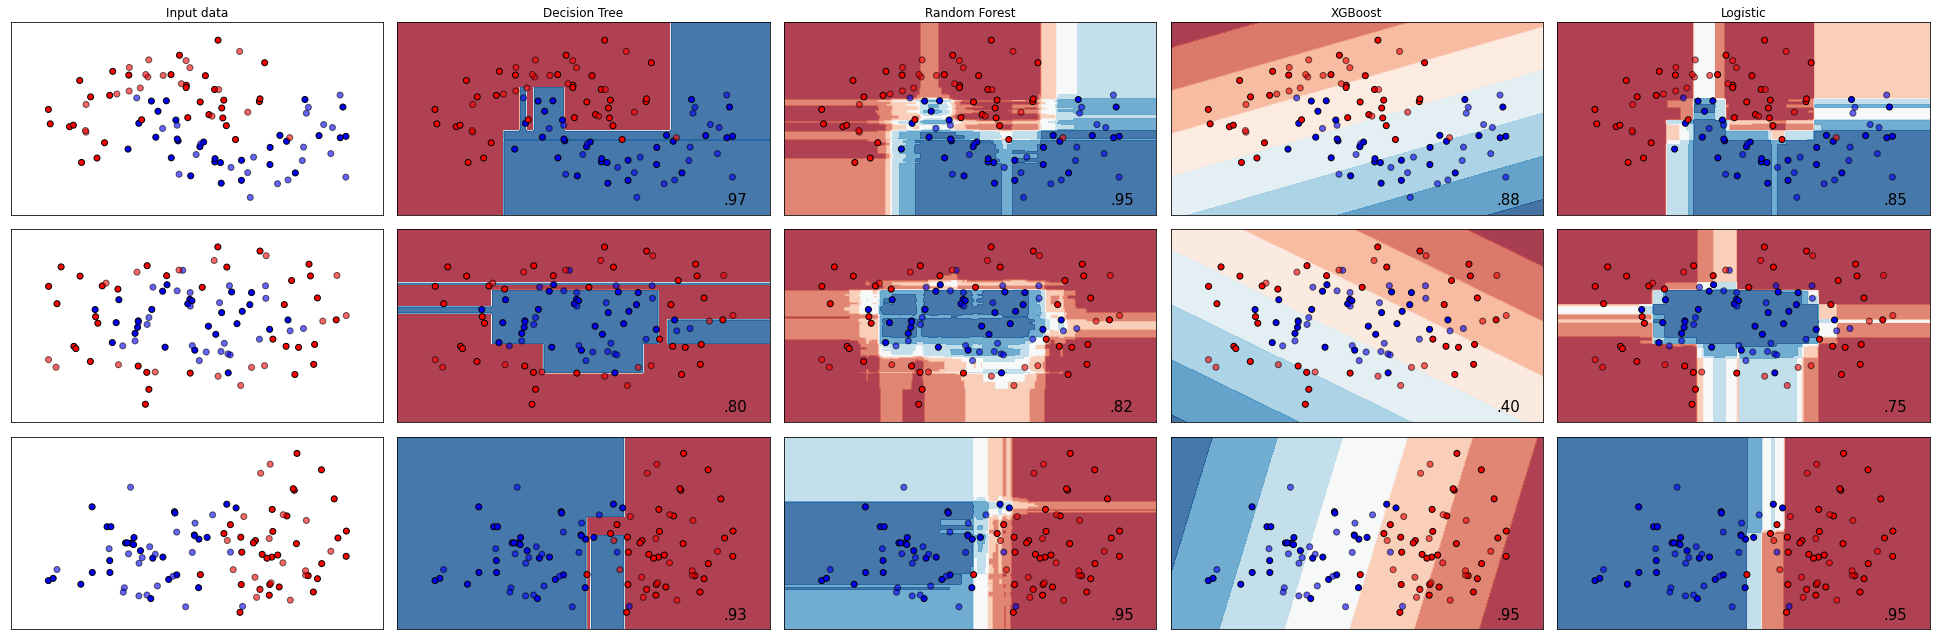

In [52]:
finalPredict(dji_target, dji_features, dctEval, forestEval, logisticEval, xgbEval)
h = 0.02  # step size in the mesh

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

<h1>Nikkei 225 Stock Average</h1>

<h2>Feature Selection</h2>

In [53]:
n225['Future Close'] = n225['Close'].shift(-1)
n225

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,18951.119141,18394.429688,18818.580078,18450.980469,140200000.0,18450.980469,18374.000000
2016-01-05,18547.380859,18327.519531,18398.759766,18374.000000,132300000.0,18374.000000,18191.320312
2016-01-06,18469.380859,18064.300781,18410.570312,18191.320312,142200000.0,18191.320312,17767.339844
2016-01-07,18172.039062,17767.339844,18139.769531,17767.339844,168000000.0,17767.339844,17697.960938
2016-01-08,17975.310547,17509.640625,17562.230469,17697.960938,184300000.0,17697.960938,17218.960938
...,...,...,...,...,...,...,...
2021-11-25,29570.419922,29444.449219,29469.650391,29499.279297,50700000.0,29499.279297,28751.619141
2021-11-26,29332.990234,28605.609375,29324.470703,28751.619141,72900000.0,28751.619141,28283.919922
2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922,27821.759766


In [54]:
target = computeTarget(n225['Close'], n225['Future Close'])

n225['Target'] = target

In [55]:
close = n225['Close']
high = n225['High']
low = n225['Low']
open = n225['Open']
volume  = n225['Volume']

In [56]:
n225_ti = pd.DataFrame()
n225_ti['SMA20'] = talib.SMA(close, timeperiod=20)
n225_ti['SMA50'] = talib.SMA(close, timeperiod=50)
n225_ti['SMA200'] = talib.SMA(close, timeperiod=200)
n225_ti['EMA'] = talib.EMA(close, timeperiod=14)
n225_ti['OBV'] = talib.OBV(close, volume)
n225_ti['RSI14'] = talib.RSI(close, timeperiod=14)
n225_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
n225_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
n225_ti['aroondown'], n225_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
n225_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
n225_ti['BOP'] = talib.BOP(open, high, low, close)
n225_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
n225_ti['CMO'] = talib.CMO(close, timeperiod=14)
n225_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
n225_ti['macd'],n225_ti['macdsignal'],n225_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
n225_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
n225_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
n225_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
n225_ti['MOM'] = talib.MOM(close, timeperiod=14)
n225_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
n225_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
n225_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['ROC'] = talib.ROC(close, timeperiod=10)
n225_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
n225_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
n225_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
n225_ti['slowk'], n225_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
n225_ti['fastk'], n225_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
n225_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
n225_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
n225_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
n225_ti['Target'] = n225['Target']
n225_ti['Re Target'] = n225['Close']
n225_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.402000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18450.980469
2016-01-05,NaN,NaN,NaN,NaN,7.900000e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18374.000000
2016-01-06,NaN,NaN,NaN,NaN,-1.343000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18191.320312
2016-01-07,NaN,NaN,NaN,NaN,-3.023000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17767.339844
2016-01-08,NaN,NaN,NaN,NaN,-4.866000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17697.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,29468.294434,29289.329609,28945.491924,29508.844071,5.749200e+09,52.268756,10.223250,12.584760,35.714286,57.142857,...,101.348483,42.552319,48.229238,48.242696,42.552319,0.044643,49.080570,-50.133093,0,29499.279297
2021-11-26,29450.963379,29255.414609,28947.439170,29407.880747,5.676300e+09,41.224743,11.884684,13.210618,100.000000,50.000000,...,98.202600,24.424769,37.981001,12.158555,24.424769,0.044831,41.192014,-89.226918,0,28751.619141
2021-11-29,29424.154883,29207.691016,28945.626270,29258.019304,5.590400e+09,36.087929,14.019772,13.770901,100.000000,42.857143,...,95.521607,22.126310,29.701132,5.977677,22.126310,0.043856,39.061709,-94.542778,0,28283.919922


In [57]:

n225_target = n225_ti.tail(1)

In [58]:
n225_ti = n225_ti.dropna()
n225_features = selectFeatures(n225_ti, 'Target')
n225_features

['RSI14',
 'ADX',
 'ADXR',
 'aroondown',
 'BOP',
 'CMO',
 'DX',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [59]:
X = n225_ti.loc[:, n225_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = n225_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [60]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [61]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [63]:
# Look at the actual y_test
#
y_test

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [64]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.508
Confusion Matrix: 
 [[63 63]
 [60 64]]
F1 Score:  0.5099601593625498
Precision Score:  0.5039370078740157
Recall score:  0.5161290322580645
Area Under Curve score:  0.5080645161290323


<h2>Random Forest</h2>

In [65]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 43, max_depth=4, min_samples_split=2 )
forest.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_23104/2696115339.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=43)

In [66]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1], dtype=int64)

In [67]:
y_test

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [68]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.536
Confusion Matrix: 
 [[59 67]
 [49 75]]
F1 Score:  0.5639097744360901
Precision Score:  0.528169014084507
Recall score:  0.6048387096774194
Area Under Curve score:  0.5365463389656938


<h2>Logistic Regression</h2>

In [69]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [70]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

In [71]:
# Look at the actual y_test
y_test

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [72]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.52
Confusion Matrix: 
 [[53 73]
 [47 77]]
F1 Score:  0.5620437956204379
Precision Score:  0.5133333333333333
Recall score:  0.6209677419354839
Area Under Curve score:  0.5208013312852022


<h2>XGBoost</h2>

In [73]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[18:33:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1], dtype=int64)

In [75]:
y_test

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [76]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.512
Confusion Matrix: 
 [[63 63]
 [59 65]]
F1 Score:  0.5158730158730158
Precision Score:  0.5078125
Recall score:  0.5241935483870968
Area Under Curve score:  0.5120967741935484


<h2>Linear Regress</h2>

In [77]:
n225_features = selectFeatures(n225_ti,'Re Target')
n225_features

['EMA',
 'RSI14',
 'ADX',
 'ADXR',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'TRIX',
 'ULTOSC']

In [78]:
from sklearn.model_selection import train_test_split
X = n225_ti.loc[:, n225_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = n225_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [80]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 3.20169013e+03  2.16505526e+02  1.72501400e+01 -2.86148488e+01
   1.45552617e+01  2.16505526e+02 -1.44765958e+02 -8.56874864e+00
   2.13370738e+02 -5.02413031e+02 -2.50089578e+02  3.69959634e+02
  -4.29041979e+01 -7.67901800e-01  1.53713182e+01 -1.91744925e+01
   2.63081420e+01 -9.61680894e+00  1.34238255e+01]]
Intercept: [22803.11861509]


In [82]:
predicted = lr.predict(X_train)
print(predicted)

[[22691.71086412]
 [21671.71780623]
 [21613.87626256]
 [23299.30359601]
 [22129.57530185]
 [29433.39859233]
 [28817.51634831]
 [23236.09943914]
 [29340.63099301]
 [28030.65205108]
 [29976.24191172]
 [24167.75147854]
 [21725.49506299]
 [21481.79598759]
 [22645.73991317]
 [29186.81602907]
 [21944.97507195]
 [24270.99564946]
 [17711.30345757]
 [29128.99513485]
 [19809.10012533]
 [21000.77248846]
 [28552.93172868]
 [19840.3537583 ]
 [23569.97606925]
 [19227.9746964 ]
 [22700.54843325]
 [19046.02454084]
 [20634.18008286]
 [21154.47882296]
 [27754.34670317]
 [21489.51793447]
 [28574.5297481 ]
 [28945.88849298]
 [21526.53969054]
 [19355.97057723]
 [29811.60753476]
 [23889.66385194]
 [23323.69480488]
 [21281.96720705]
 [24316.43117899]
 [21773.46983904]
 [23377.00189585]
 [18812.79331636]
 [21449.27593342]
 [21982.31073311]
 [22318.21758514]
 [22462.9462002 ]
 [23259.41168212]
 [22860.75534016]
 [21140.93353721]
 [23403.25081746]
 [18902.23019586]
 [29564.04008382]
 [22778.57124861]
 [24104.96

In [83]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [84]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Absolute Error:  23192.81096484375
Mean Squared Error 549405432.3595576


<AxesSubplot:>

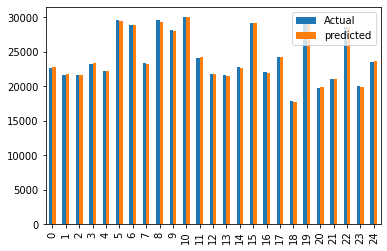

In [85]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gauccian Process Regression</h2>

In [86]:
n225_refeatures = selectFeatures(n225_ti,'Re Target')
n225_refeatures

['EMA',
 'RSI14',
 'ADX',
 'ADXR',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'TRIX',
 'ULTOSC']

In [87]:
Xr = n225_ti.loc[:, n225_refeatures].values
yr = n225_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [88]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [89]:
from sklearn.gaussian_process import GaussianProcessRegressor
gs = GaussianProcessRegressor()
gs.fit(Xr_train, yr_train)

GaussianProcessRegressor()

In [90]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[1.50737746e+04],
       [1.69559475e+04],
       [2.14655100e+04],
       [1.32649084e+04],
       [1.89210101e+04],
       [2.39161633e+04],
       [1.86913964e+04],
       [1.99420827e+04],
       [2.07768403e+04],
       [1.60971778e+04],
       [2.22351199e+04],
       [1.50862543e+04],
       [3.78953529e+03],
       [1.51742907e+04],
       [1.39169236e+04],
       [2.55441236e+04],
       [9.56440811e+03],
       [2.01742941e+04],
       [2.94364788e+04],
       [1.83638368e+04],
       [1.61804526e+04],
       [1.93414618e+04],
       [1.59888915e+04],
       [2.43885244e+04],
       [1.59399496e+04],
       [1.71516020e+04],
       [2.20468532e+04],
       [1.66687628e+04],
       [4.03540453e+02],
       [1.31006464e+04],
       [1.40462449e+04],
       [1.33155581e+04],
       [1.60948500e+04],
       [1.06999647e+04],
       [6.99002759e+03],
       [2.53771721e+04],
       [1.60260795e+04],
       [2.42469692e+04],
       [1.63148475e+04],
       [1.48609339e+04],


In [91]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Mean Absolute Error:  7148.531469274815
Mean Squared Error 86077134.17099726


[0, 1, 1, 0]
[1, 1, 0]
The final prediction is Up


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


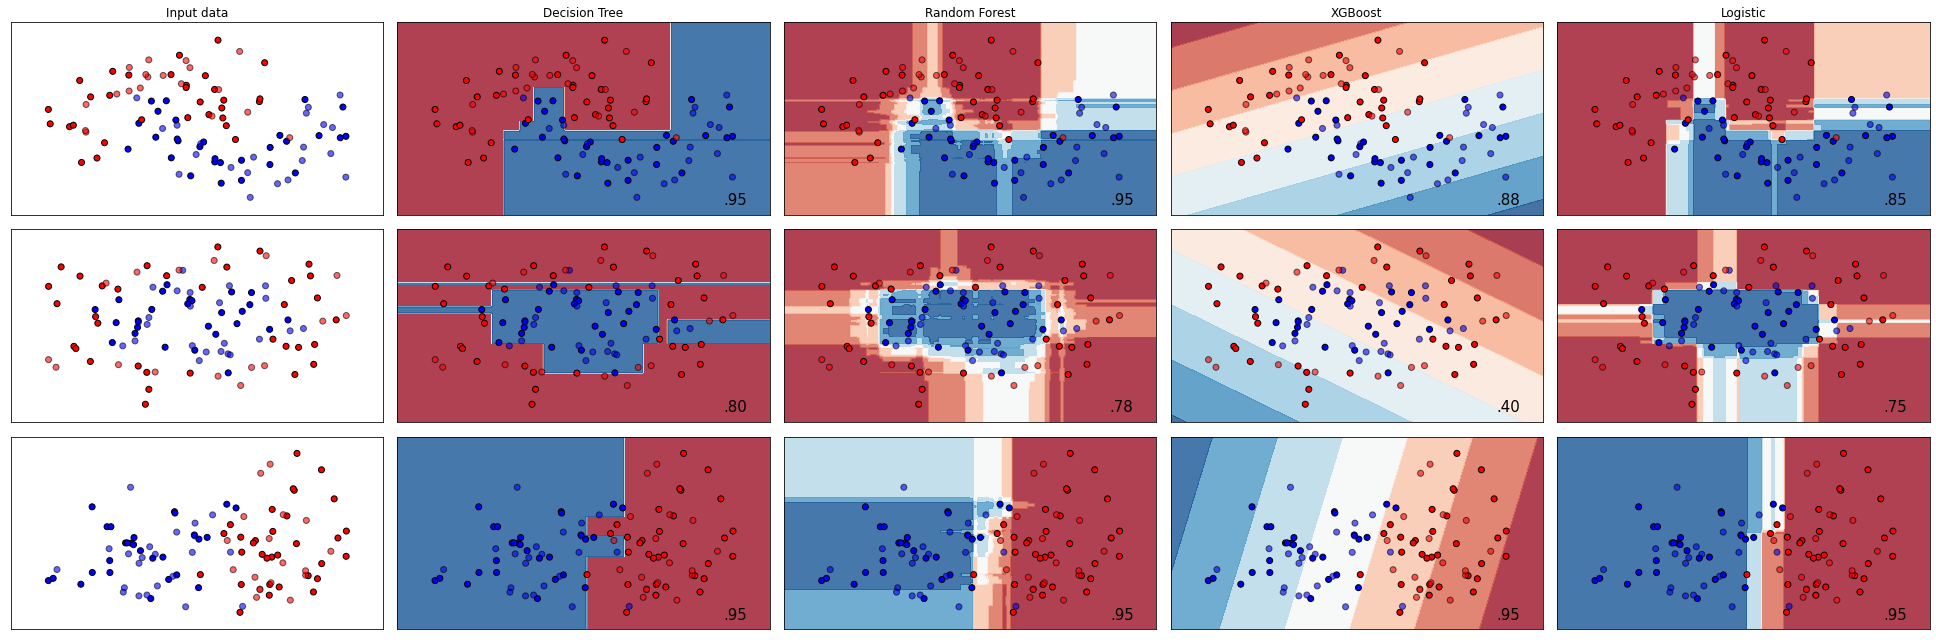

In [92]:
finalPredict(n225_target, n225_features, dctEval, forestEval, logisticEval, xgbEval)
h = 0.02  

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
   
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

   
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
   
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
   
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

      
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

<h1>Heng Seng Index</h1>

<h2>Feature Selection</h2>

In [93]:
hsi['Future Close'] = hsi['Close'].shift(-1)
hsi

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,21794.839844,21227.609375,21782.619141,21327.119141,1.712095e+09,21327.119141,21188.720703
2016-01-05,21452.740234,21095.900391,21318.689453,21188.720703,1.484745e+09,21188.720703,20980.810547
2016-01-06,21199.619141,20947.300781,21142.630859,20980.810547,1.651083e+09,20980.810547,20333.339844
2016-01-07,20826.439453,20323.970703,20772.599609,20333.339844,2.982004e+09,20333.339844,20453.710938
2016-01-08,20596.419922,20324.619141,20491.880859,20453.710938,2.078133e+09,20453.710938,19888.500000
...,...,...,...,...,...,...,...
2021-11-25,24762.609375,24532.820312,24699.689453,24740.160156,1.188635e+09,24740.160156,24080.519531
2021-11-26,24502.679688,24062.259766,24502.679688,24080.519531,1.804123e+09,24080.519531,23852.240234
2021-11-29,24134.320312,23774.310547,23910.490234,23852.240234,1.741008e+09,23852.240234,23475.259766


In [94]:
target = computeTarget(hsi['Close'], hsi['Future Close'])

hsi['Target'] = target


In [95]:
close = hsi['Close']
high = hsi['High']
low = hsi['Low']
open = hsi['Open']
volume  = hsi['Volume']

In [96]:
hsi_ti = pd.DataFrame()
hsi_ti['SMA20'] = talib.SMA(close, timeperiod=20)
hsi_ti['SMA50'] = talib.SMA(close, timeperiod=50)
hsi_ti['SMA200'] = talib.SMA(close, timeperiod=200)
hsi_ti['EMA'] = talib.EMA(close, timeperiod=14)
hsi_ti['OBV'] = talib.OBV(close, volume)
hsi_ti['RSI14'] = talib.RSI(close, timeperiod=14)
hsi_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
hsi_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
hsi_ti['aroondown'], hsi_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
hsi_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
hsi_ti['BOP'] = talib.BOP(open, high, low, close)
hsi_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
hsi_ti['CMO'] = talib.CMO(close, timeperiod=14)
hsi_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
hsi_ti['macd'],hsi_ti['macdsignal'],hsi_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
hsi_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
hsi_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
hsi_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
hsi_ti['MOM'] = talib.MOM(close, timeperiod=14)
hsi_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
hsi_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
hsi_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['ROC'] = talib.ROC(close, timeperiod=10)
hsi_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
hsi_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
hsi_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
hsi_ti['slowk'], hsi_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
hsi_ti['fastk'], hsi_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
hsi_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
hsi_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
hsi_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
hsi_ti['Target'] = hsi['Target']
hsi_ti['Re Target'] = hsi['Close']
hsi_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.712095e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21327.119141
2016-01-05,NaN,NaN,NaN,NaN,2.273497e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21188.720703
2016-01-06,NaN,NaN,NaN,NaN,-1.423734e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20980.810547
2016-01-07,NaN,NaN,NaN,NaN,-4.405738e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20333.339844
2016-01-08,NaN,NaN,NaN,NaN,-2.327604e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20453.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,25102.686133,25061.223086,27362.739688,25053.106896,1.865568e+11,41.372271,14.491911,14.738883,21.428571,50.000000,...,97.988632,18.205935,14.168091,36.559562,18.205935,-0.056835,47.340652,-79.540863,0,24740.160156
2021-11-26,25037.850098,25026.557266,27336.604980,24923.428580,1.847527e+11,32.311086,16.161043,15.541943,100.000000,42.857143,...,95.074808,17.749029,15.509999,1.759656,17.749029,-0.056914,37.989503,-98.915981,0,24080.519531
2021-11-29,24972.746094,24993.557461,27310.298682,24780.603467,1.830117e+11,29.872744,18.157605,16.725154,100.000000,35.714286,...,93.940076,15.184520,17.046495,7.234342,15.184520,-0.058054,37.122164,-96.048992,0,23852.240234


In [97]:
hsi_target = hsi_ti.tail(1)

In [98]:
hsi_ti = hsi_ti.dropna()
hsi_features = selectFeatures(hsi_ti,'Target')
hsi_features

['ADX',
 'APO',
 'BOP',
 'CCI',
 'CMO',
 'DX',
 'macd',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'TRIX',
 'WILLR']

In [99]:
X = hsi_ti.loc[:, hsi_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [100]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [101]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [102]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int64)

In [103]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [104]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.46825396825396826
Confusion Matrix: 
 [[53 63]
 [71 65]]
F1 Score:  0.4924242424242424
Precision Score:  0.5078125
Recall score:  0.47794117647058826
Area Under Curve score:  0.4674188640973631


<h2>Random Forest</h2>

In [105]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 40, max_depth=2 )
forest.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_23104/33020272.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=40)

In [106]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [107]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.5079365079365079
Confusion Matrix: 
 [[  5 111]
 [ 13 123]]
F1 Score:  0.6648648648648648
Precision Score:  0.5256410256410257
Recall score:  0.9044117647058824
Area Under Curve score:  0.47375760649087223


<h2>Logistic Regression</h2>

In [108]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [109]:
# Prediction
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int64)

In [110]:
# Look at the actual y_test
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [111]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.46825396825396826
Confusion Matrix: 
 [[53 63]
 [71 65]]
F1 Score:  0.4924242424242424
Precision Score:  0.5078125
Recall score:  0.47794117647058826
Area Under Curve score:  0.4674188640973631


<h2>XGBoost</h2>

In [112]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[18:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0], dtype=int64)

In [114]:
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [115]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5317460317460317
Confusion Matrix: 
 [[59 57]
 [61 75]]
F1 Score:  0.5597014925373136
Precision Score:  0.5681818181818182
Recall score:  0.5514705882352942
Area Under Curve score:  0.5300456389452333


<h2>Linear Regression</h2>

In [116]:
hsi_features = selectFeatures(hsi_ti,'Re Target')
hsi_features

['EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'WILLR',
 'Target']

In [117]:
from sklearn.model_selection import train_test_split
X = hsi_ti.loc[:, hsi_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [118]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [119]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [120]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 2.26622678e+03  7.92697773e+12  5.38863835e+00  1.70000722e+01
  -7.92697773e+12 -2.26525894e+02 -2.45654203e+01  2.58609318e+02
  -5.14919488e+02 -2.49963575e+02  3.41116117e+02  2.47233701e+01
  -2.68312799e+14  2.68312799e+14 -9.86534353e+00  4.88772014e+01
   2.48439410e+01 -1.13660278e+01  5.48553467e-03]]
Intercept: [26891.3068233]


In [121]:
predicted = lr.predict(X_train)
print(predicted)

[[25654.59850859]
 [27700.85879323]
 [27073.36327031]
 ...
 [24494.44205958]
 [27965.79072664]
 [26101.93385441]]


In [122]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [123]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Absolute Error:  26944.37889074901
Mean Squared Error 731457440.7755752


<AxesSubplot:>

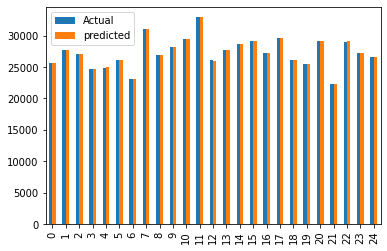

In [124]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gauccian Process Regression</h2>

In [125]:
hsi_refeatures = selectFeatures(hsi_ti,'Re Target')
hsi_refeatures

['EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'WILLR',
 'Target']

In [126]:
Xr = hsi_ti.loc[:, hsi_refeatures].values
yr = hsi_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [127]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [128]:
from sklearn.gaussian_process import GaussianProcessRegressor
gs = GaussianProcessRegressor()
gs.fit(Xr_train, yr_train)

GaussianProcessRegressor()

In [129]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[19364.92754766],
       [12137.22828553],
       [12152.67671361],
       [26743.41789694],
       [21792.72590162],
       [18618.16495208],
       [ 7305.77354932],
       [ 6749.19815317],
       [12098.42586116],
       [34372.63969045],
       [18355.66775316],
       [15996.19688952],
       [13801.4192367 ],
       [27189.04865972],
       [19702.7301516 ],
       [28128.74752664],
       [10153.22124436],
       [18125.34615209],
       [17527.08104884],
       [29780.0189652 ],
       [15816.82479683],
       [14326.37168027],
       [25918.40163218],
       [12907.37157599],
       [16090.60492204],
       [19719.95474029],
       [14765.24516862],
       [ 2894.02059593],
       [27584.2535192 ],
       [23066.23180096],
       [22042.92147728],
       [17991.74179576],
       [30808.21470062],
       [ 6150.35024331],
       [ 1105.40381157],
       [23886.24842531],
       [23884.78717463],
       [ 9554.22088715],
       [19122.97149791],
       [ 6546.10812767],


In [130]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Mean Absolute Error:  9894.428142993293
Mean Squared Error 142044863.12946007


[1, 0, 0, 1]
[0, 0, 1]
The final prediction is Down


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


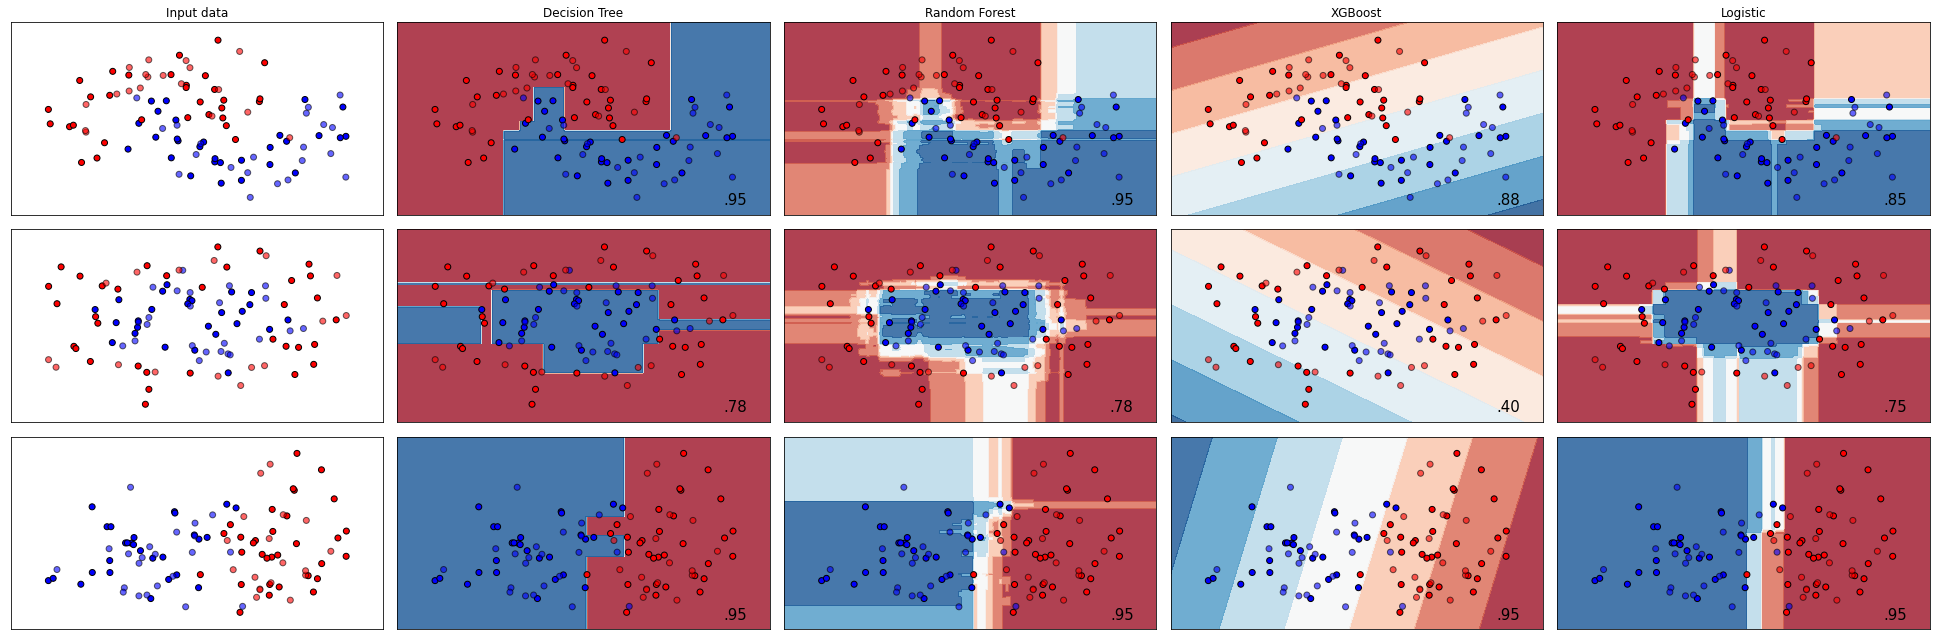

In [131]:
finalPredict(hsi_target, hsi_features, dctEval, forestEval, logisticEval, xgbEval)
h = 0.02  # step size in the mesh

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

   
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
   
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
   
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

      
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()


<h1>SSE Composite Index</h1>

<h2>Feature Selection</h2>

In [132]:
sse['Future Close'] = sse['Close'].shift(-1)
sse

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,3538.688965,3295.740967,3536.589111,3296.258057,184400,3296.258057,3287.710938
2016-01-05,3328.138916,3189.604980,3196.650879,3287.710938,266900,3287.710938,3361.840088
2016-01-06,3362.974121,3288.933105,3291.195068,3361.840088,238900,3361.840088,3125.001953
2016-01-07,3309.656982,3115.885010,3309.656982,3125.001953,70600,3125.001953,3186.412109
2016-01-08,3235.450928,3056.877930,3194.625000,3186.412109,286400,3186.412109,3016.704102
...,...,...,...,...,...,...,...
2021-11-25,3597.149902,3579.530029,3593.389893,3584.179932,306500,3584.179932,3564.090088
2021-11-26,3576.110107,3554.879883,3576.110107,3564.090088,301000,3564.090088,3562.699951
2021-11-29,3563.679932,3526.360107,3528.669922,3562.699951,333600,3562.699951,3563.889893


In [133]:
target = computeTarget(sse['Close'], sse['Future Close'])

sse['Target'] = target

In [134]:
close = sse['Close']
high = sse['High']
low = sse['Low']
open = sse['Open']
volume  = sse['Volume']

In [135]:
sse_ti = pd.DataFrame()
sse_ti['SMA20'] = talib.SMA(close, timeperiod=20)
sse_ti['SMA50'] = talib.SMA(close, timeperiod=50)
sse_ti['SMA200'] = talib.SMA(close, timeperiod=200)
sse_ti['EMA'] = talib.EMA(close, timeperiod=14)
sse_ti['OBV'] = talib.OBV(close, volume)
sse_ti['RSI14'] = talib.RSI(close, timeperiod=14)
sse_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
sse_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
sse_ti['aroondown'], sse_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
sse_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
sse_ti['BOP'] = talib.BOP(open, high, low, close)
sse_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
sse_ti['CMO'] = talib.CMO(close, timeperiod=14)
sse_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
sse_ti['macd'],sse_ti['macdsignal'],sse_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
sse_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
sse_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
sse_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
sse_ti['MOM'] = talib.MOM(close, timeperiod=14)
sse_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
sse_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
sse_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['ROC'] = talib.ROC(close, timeperiod=10)
sse_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
sse_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
sse_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
sse_ti['slowk'], sse_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
sse_ti['fastk'], sse_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
sse_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
sse_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
sse_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
sse_ti['Target'] = sse['Target']
sse_ti['Re Target'] = sse['Close']
sse_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.844000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3296.258057
2016-01-05,NaN,NaN,NaN,NaN,-8.250000e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3287.710938
2016-01-06,NaN,NaN,NaN,NaN,1.564000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3361.840088
2016-01-07,NaN,NaN,NaN,NaN,8.580000e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3125.001953
2016-01-08,NaN,NaN,NaN,NaN,3.722000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3186.412109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,3535.300122,3576.862051,3526.284808,3556.436939,2.515870e+07,56.741498,20.007708,22.963771,21.428571,92.857143,...,101.454655,85.369349,90.150459,78.192242,85.369349,-0.008130,67.810240,-12.025766,0,3584.179932
2021-11-26,3536.137622,3574.640054,3526.238558,3557.457359,2.485770e+07,52.144400,18.673887,22.533847,14.285714,85.714286,...,100.706111,62.081553,79.550737,19.245976,62.081553,-0.007953,61.348117,-25.046163,0,3564.090088
2021-11-29,3537.048621,3572.031455,3526.526178,3558.156371,2.452410e+07,51.831473,18.346326,22.970243,7.142857,78.571429,...,100.832081,48.339676,65.263526,47.580810,48.339676,-0.007703,68.169630,-25.947123,1,3562.699951


In [136]:
sse_target = hsi_ti.tail(1)

In [137]:
sse_ti = sse_ti.dropna()
sse_features = selectFeatures(sse_ti,'Target')
sse_features

['SMA20',
 'EMA',
 'APO',
 'BOP',
 'CCI',
 'DX',
 'macd',
 'macdsignal',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastd',
 'TRIX']

In [138]:
X = sse_ti.loc[:, sse_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = sse_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [139]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [140]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [141]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1], dtype=int64)

In [142]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [143]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.5040322580645161
Confusion Matrix: 
 [[49 69]
 [54 76]]
F1 Score:  0.5527272727272728
Precision Score:  0.5241379310344828
Recall score:  0.5846153846153846
Area Under Curve score:  0.4999348109517602


<h2>Random Forest</h2>

In [144]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features=9)
forest.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_23104/371548984.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_features=9, n_estimators=1000, random_state=42)

In [145]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1], dtype=int64)

In [146]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.5120967741935484
Confusion Matrix: 
 [[48 70]
 [51 79]]
F1 Score:  0.5663082437275985
Precision Score:  0.5302013422818792
Recall score:  0.6076923076923076
Area Under Curve score:  0.5072359843546285


<h2>Logistic Regression</h2>

In [147]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [148]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0], dtype=int64)

In [149]:
# Look at the actual y_test
y_test

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [150]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.4879032258064516
Confusion Matrix: 
 [[38 80]
 [47 83]]
F1 Score:  0.5665529010238907
Precision Score:  0.50920245398773
Recall score:  0.6384615384615384
Area Under Curve score:  0.4802477183833116


<h2>XGBoost</h2>

In [151]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

[18:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1], dtype=int64)

In [153]:
y_test

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [154]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5241935483870968
Confusion Matrix: 
 [[53 65]
 [53 77]]
F1 Score:  0.5661764705882353
Precision Score:  0.5422535211267606
Recall score:  0.5923076923076923
Area Under Curve score:  0.5207301173402868


<h2>Linear Regression</h2>

In [155]:
sse_features = selectFeatures(sse_ti,'Re Target')
sse_features

['SMA20',
 'SMA50',
 'EMA',
 'RSI14',
 'ADXR',
 'APO',
 'BOP',
 'CMO',
 'macd',
 'macdsignal',
 'macdhist',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'TRIX']

In [156]:
from sklearn.model_selection import train_test_split
X = sse_ti.loc[:, sse_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = sse_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [157]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [158]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [159]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 1.26078462e+02 -5.79522486e+01  2.10952762e+02  6.99423087e+11
  -1.13825164e+00  4.06649799e+00  3.27982612e+00 -6.99423087e+11
   1.25667440e+11 -1.16910992e+11 -4.10759306e+10  2.85861840e+01
  -4.88692417e+01 -2.81824671e+01  4.87128651e+01  6.62405952e+00
  -3.01281540e+13  3.01281540e+13  9.54481507e-01]]
Intercept: [3153.91983911]


In [160]:
predicted = lr.predict(X_train)
print(predicted)

[[2874.26570502]
 [3420.06261698]
 [3066.61780004]
 [2796.60967368]
 [3351.60860976]
 [2710.83934566]
 [2891.82777224]
 [3492.80316204]
 [3484.6559287 ]
 [3618.77198792]
 [3423.81967127]
 [2938.73929873]
 [3094.48947522]
 [3334.88774648]
 [3257.64478448]
 [3478.66469891]
 [2730.77326357]
 [3219.84575552]
 [3521.46336567]
 [3087.56775057]
 [2520.49695311]
 [3611.07517373]
 [3279.6089997 ]
 [3329.89132734]
 [3231.41535988]
 [2642.56507195]
 [3145.53054536]
 [3552.85511587]
 [3482.66556251]
 [2930.4714773 ]
 [3004.66323785]
 [2926.26705279]
 [3582.55151144]
 [2980.85287209]
 [3221.25165119]
 [3415.88032931]
 [3699.60656196]
 [2863.34675952]
 [2456.81395081]
 [2848.98321746]
 [3711.82028016]
 [2932.88089742]
 [3359.91213427]
 [2709.40753368]
 [3398.77668704]
 [3059.25918671]
 [3353.43309409]
 [3370.08648504]
 [3280.15481634]
 [3539.84389775]
 [2477.45970096]
 [3135.08945295]
 [3559.40675144]
 [2936.6675695 ]
 [3451.51158016]
 [2971.45034309]
 [3298.58446141]
 [2926.76422085]
 [3411.6115712

In [161]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [162]:
#evaluate("reg", y_test, y_pred)

lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Absolute Error:  3131.7825908045616
Mean Squared Error 9895574.945354404


<AxesSubplot:>

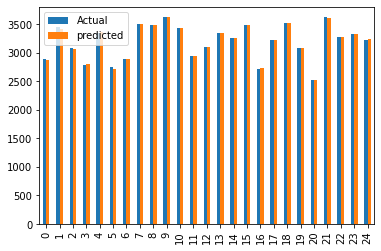

In [163]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gauccian Process Regression</h2>

[1, 1, 0, 1]
The final prediction is Up


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


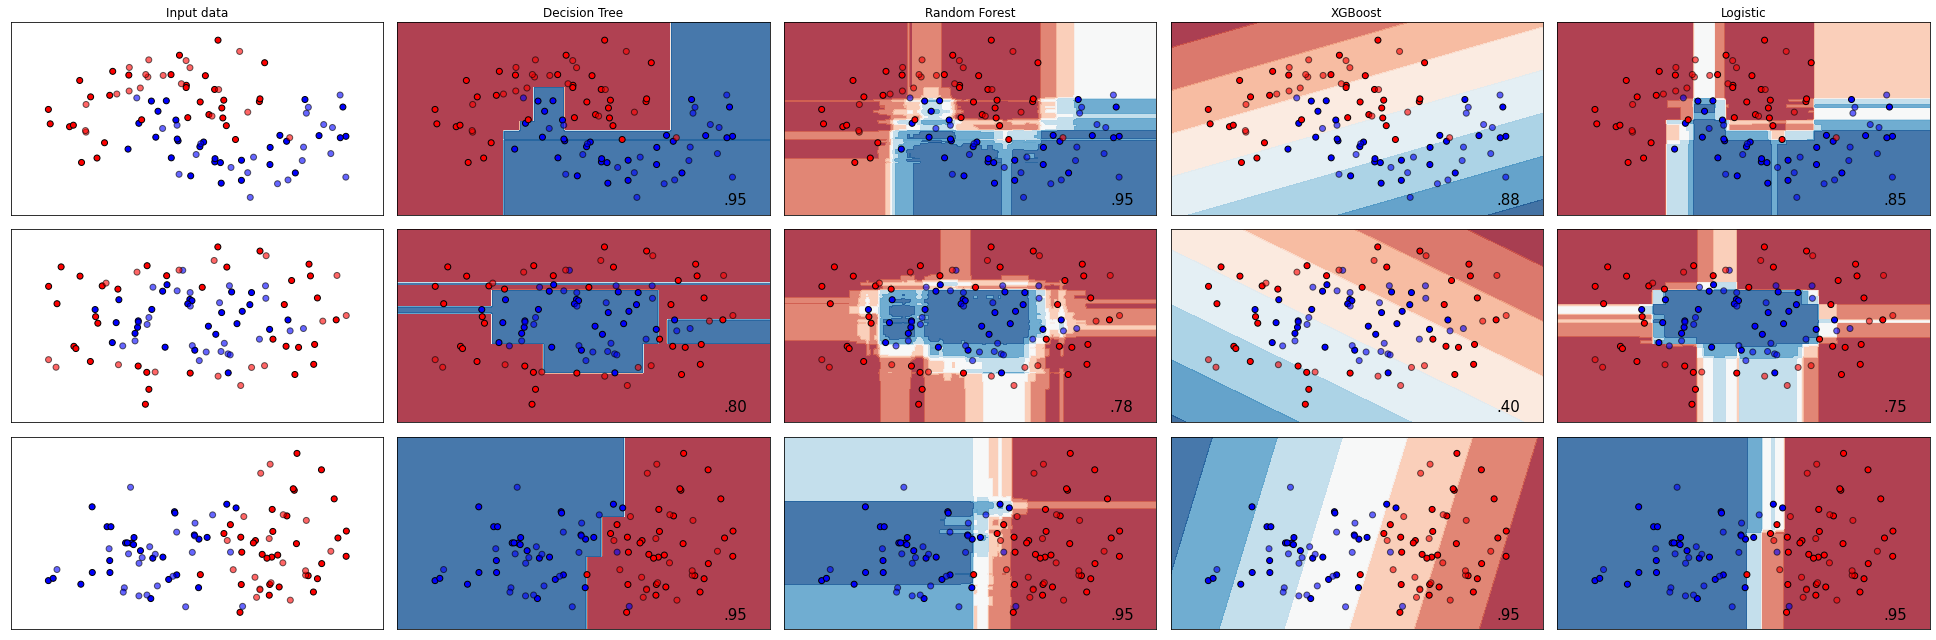

In [164]:
finalPredict(sse_target, sse_features, dctEval, forestEval, logisticEval, xgbEval)

h = 0.02  # step size in the mesh

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()